# **Introduction**

**Tujuan Proyek**: Proyek ini bertujuan untuk memprediksi kemampuan pemohon pinjaman dalam membayar kembali pinjaman.

**Deskripsi Dataset**:
1. application_train.csv: dataset utama yang digunakan untuk melatih model, dengan kolom TARGET yang menunjukkan apakah pemohon mampu membayar pinjaman. Setiap baris dalam dataset ini mewakili satu aplikasi pinjaman.
2. previous_application.csv: dataset ini mencatat seluruh aplikasi pinjaman yang diajukan sebelumnya oleh klien yang ada dalam dataset utama. Setiap baris mewakili satu aplikasi pinjaman sebelumnya, yang memberikan lebih banyak konteks dan riwayat pinjaman klien.

**Tahapan Pengolahan Data**:
1. Exploratory Data Analysis (EDA): menemukan pola atau hubungan antara variabel, mengevaluasi distribusi data, serta mengidentifikasi missing values dan outliers yang perlu ditangani.
2. Preprocessing:
    * Handling Missing Values: Menangani missing data menggunakan teknik imputasi atau penghapusan    data yang tidak relevan.
    * Handling Outliers.
    * Feature Encoding : Mengubah fitur kategorikal menjadi numerik menggunakan teknik encoding.
    * Handling Imbalanced Data: menggunakan oversampling pada kolom TARGET.
3. Modeling : Random Forest serta hyperparameter tuning dengan randomsearch.
4. Evaluasi Model : Confusion matrix dan ROC-AUC curve.

Tujuan dan Manfaat: Proyek ini diharapkan dapat membantu Home Credit dalam meningkatkan prediksi kemampuan pemohon pinjaman untuk membayar kembali. Dengan membangun model yang lebih akurat, diharapkan lebih banyak pemohon yang sebenarnya mampu membayar pinjaman akan disetujui. Selain itu, model yang baik juga dapat membantu memberikan pinjaman dengan jumlah, jangka waktu, dan jadwal pembayaran yang lebih realistis bagi pemohon, yang meningkatkan peluang mereka untuk sukses dalam membayar kembali pinjaman.

In [1]:
# pip install --upgrade pandas seaborn

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import random as rd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

# **1. Application Train**

## **a. Load Data**

In [3]:
df1 = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
df1.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [4]:
len(df1)

307511

## **b. EDA** 

In [5]:
# Setting up graphics and color palette
rcParams['figure.figsize'] = 9, 7

sns.set_context('notebook')
sns.set_style('whitegrid')

pal = sns.color_palette('Set3', n_colors=10)
pal[0], pal[1], pal[2], pal[4] = pal[0], pal[2], pal[5], pal[8]
sns.set_palette(pal)

In [6]:
def find_missing (data):
    missing_count = data.isnull().sum().values
    total=len(data)
    ratio_missing=missing_count/total*100
    return pd.DataFrame(data={'column name':data.columns.values, 'missing_ratio':ratio_missing})

In [7]:
find_missing(df1).sort_values(['missing_ratio'], ascending=False).head(20)

column name  missing_ratio
76           COMMONAREA_MEDI      69.872297
48            COMMONAREA_AVG      69.872297
62           COMMONAREA_MODE      69.872297
56   NONLIVINGAPARTMENTS_AVG      69.432963
70  NONLIVINGAPARTMENTS_MODE      69.432963
84  NONLIVINGAPARTMENTS_MEDI      69.432963
86        FONDKAPREMONT_MODE      68.386172
82     LIVINGAPARTMENTS_MEDI      68.354953
68     LIVINGAPARTMENTS_MODE      68.354953
54      LIVINGAPARTMENTS_AVG      68.354953
66            FLOORSMIN_MODE      67.848630
80            FLOORSMIN_MEDI      67.848630
52             FLOORSMIN_AVG      67.848630
75          YEARS_BUILD_MEDI      66.497784
61          YEARS_BUILD_MODE      66.497784
47           YEARS_BUILD_AVG      66.497784
21               OWN_CAR_AGE      65.990810
67             LANDAREA_MODE      59.376738
81             LANDAREA_MEDI      59.376738
53              LANDAREA_AVG      59.376738

In [8]:
categorical_cols = df1.select_dtypes(include=['object', 'category']).columns
categorical_cols_df = pd.DataFrame(categorical_cols, columns=['Categorical Columns'])
categorical_cols_df

Categorical Columns
0           NAME_CONTRACT_TYPE
1                  CODE_GENDER
2                 FLAG_OWN_CAR
3              FLAG_OWN_REALTY
4              NAME_TYPE_SUITE
5             NAME_INCOME_TYPE
6          NAME_EDUCATION_TYPE
7           NAME_FAMILY_STATUS
8            NAME_HOUSING_TYPE
9              OCCUPATION_TYPE
10  WEEKDAY_APPR_PROCESS_START
11           ORGANIZATION_TYPE
12          FONDKAPREMONT_MODE
13              HOUSETYPE_MODE
14          WALLSMATERIAL_MODE
15         EMERGENCYSTATE_MODE

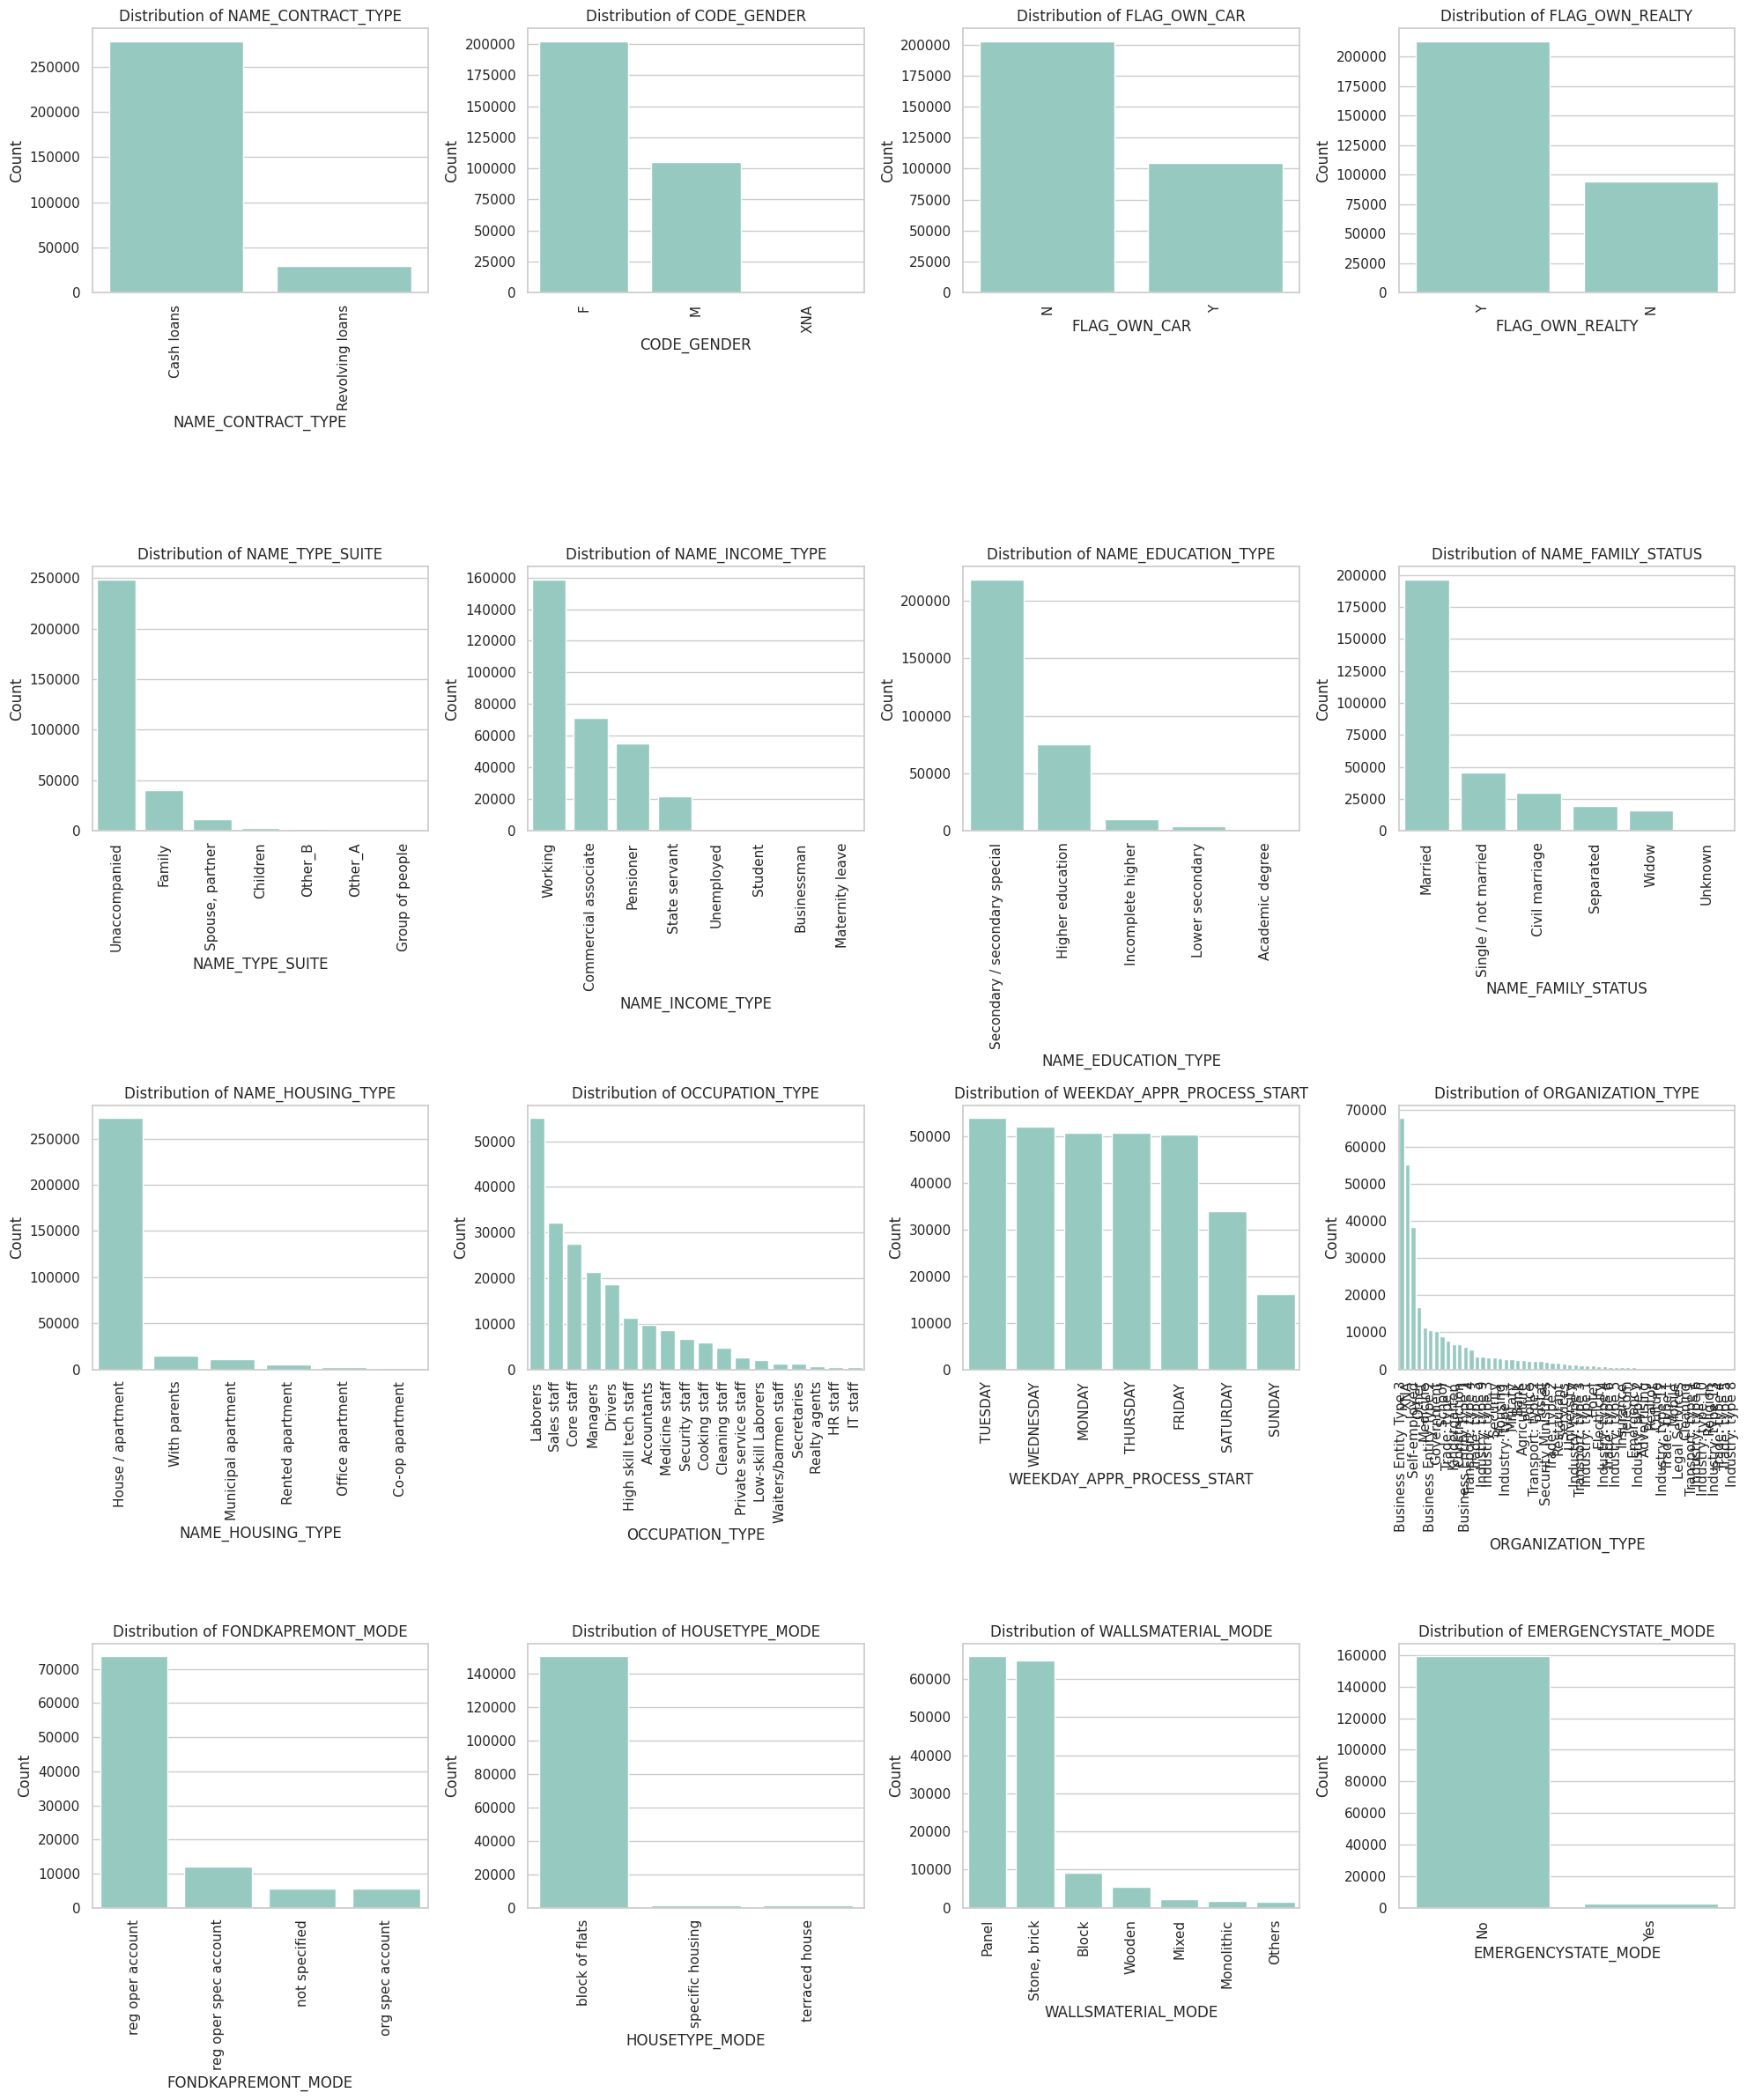

In [9]:
n_cols = 4  
n_rows = -(-len(categorical_cols) // n_cols) 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))  
axes = axes.flatten()  

for i, col in enumerate(categorical_cols):
    value_counts = df1[col].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [10]:
# for col in categorical_cols:
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=df1[col].value_counts().index, y=df1[col].value_counts().values)
#     plt.title(f'Distribution of {col}')
#     plt.xticks(rotation=45) 
#     plt.show()

In [11]:
# handling unknown categorical data using mode
mode_gender = df1['CODE_GENDER'].mode()[0]
df1['CODE_GENDER'] = df1['CODE_GENDER'].replace('XNA', mode_gender)

mode_family_status = df1['NAME_FAMILY_STATUS'].mode()[0]
df1['NAME_FAMILY_STATUS'] = df1['NAME_FAMILY_STATUS'].replace('Unknown', mode_family_status)

In [12]:
df1['CODE_GENDER'].value_counts()

CODE_GENDER
F    202452
M    105059
Name: count, dtype: int64

In [13]:
df1['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 196434
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Name: count, dtype: int64

In [14]:
numerical_cols = df1.select_dtypes(include=['integer', 'float']).columns
numerical_cols_df = pd.DataFrame(numerical_cols, columns=['Numerical Columns'])
numerical_cols_df

Numerical Columns
0                    SK_ID_CURR
1                        TARGET
2                  CNT_CHILDREN
3              AMT_INCOME_TOTAL
4                    AMT_CREDIT
..                          ...
101   AMT_REQ_CREDIT_BUREAU_DAY
102  AMT_REQ_CREDIT_BUREAU_WEEK
103   AMT_REQ_CREDIT_BUREAU_MON
104   AMT_REQ_CREDIT_BUREAU_QRT
105  AMT_REQ_CREDIT_BUREAU_YEAR

[106 rows x 1 columns]

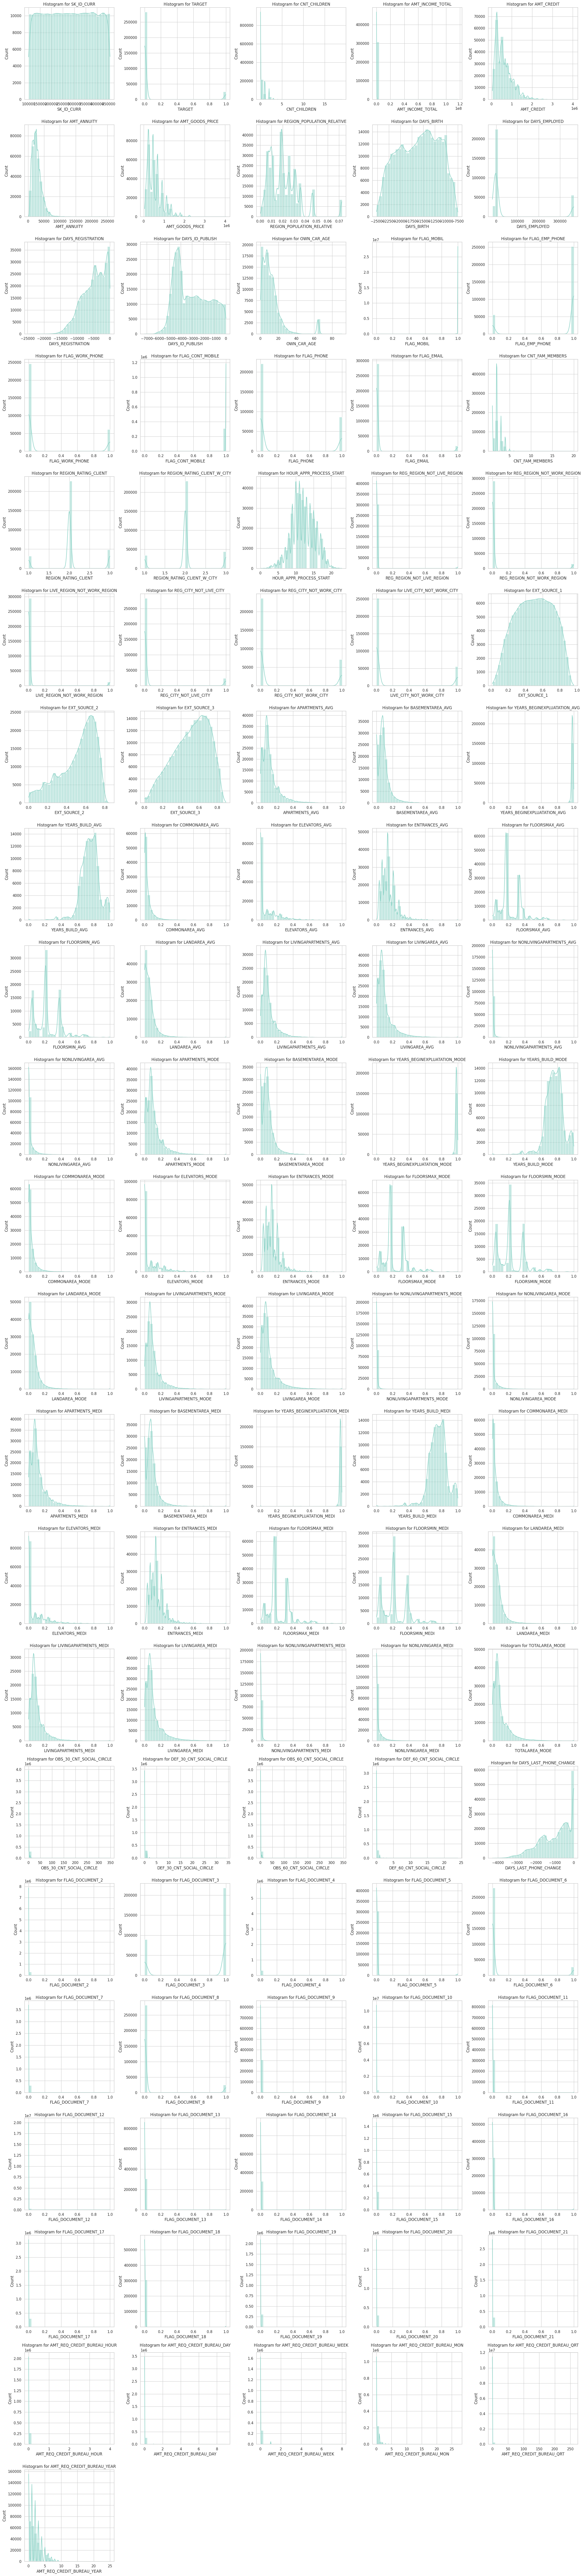

In [16]:
n_cols = 5
n_rows = -(-len(numerical_cols) // n_cols)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5 * n_rows))
axes = axes.flatten()  

for i, column in enumerate(numerical_cols) :
    sns.histplot(data=df1, x=column, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Histogram for {column}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

kolom DAYS_EMPLOYED terdapat outlier, kolom DAYS_BIRTH memiliki nilai negatif, serta terdapat banyak kolom yang terlihat mayoritas bernilai nol.

In [17]:
# Menghitung proporsi nilai 0 di setiap kolom numerikal
zero_proportion = (df1 == 0).mean().sort_values(ascending=False)

print(zero_proportion[(zero_proportion > 0.5)])

FLAG_DOCUMENT_12               0.999993
FLAG_DOCUMENT_10               0.999977
FLAG_DOCUMENT_2                0.999958
FLAG_DOCUMENT_4                0.999919
FLAG_DOCUMENT_7                0.999808
FLAG_DOCUMENT_17               0.999733
FLAG_DOCUMENT_21               0.999665
FLAG_DOCUMENT_20               0.999493
FLAG_DOCUMENT_19               0.999405
FLAG_DOCUMENT_15               0.998790
FLAG_DOCUMENT_14               0.997064
FLAG_DOCUMENT_13               0.996475
FLAG_DOCUMENT_9                0.996104
FLAG_DOCUMENT_11               0.996088
FLAG_DOCUMENT_18               0.991870
FLAG_DOCUMENT_16               0.990072
FLAG_DOCUMENT_5                0.984885
REG_REGION_NOT_LIVE_REGION     0.984856
LIVE_REGION_NOT_WORK_REGION    0.959341
REG_REGION_NOT_WORK_REGION     0.949231
FLAG_EMAIL                     0.943280
REG_CITY_NOT_LIVE_CITY         0.921827
TARGET                         0.919271
FLAG_DOCUMENT_8                0.918624
DEF_60_CNT_SOCIAL_CIRCLE       0.912881


In [18]:
df1.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868  -16036.995067   63815.045904  ...   
std                      0.013831    4363.988632  141275.766519  ...   
min                      0.000290  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19682.000000   -2760.000000  ...   
50%                      0.018850  -15750.000000   -1213.000000  ...   
75%                      0.028663  -12413.000000    -289.000000  ...   
max                      0.072508   -7489.000000  365243.000000  ...   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     0.000000                    0.000000  
25%              

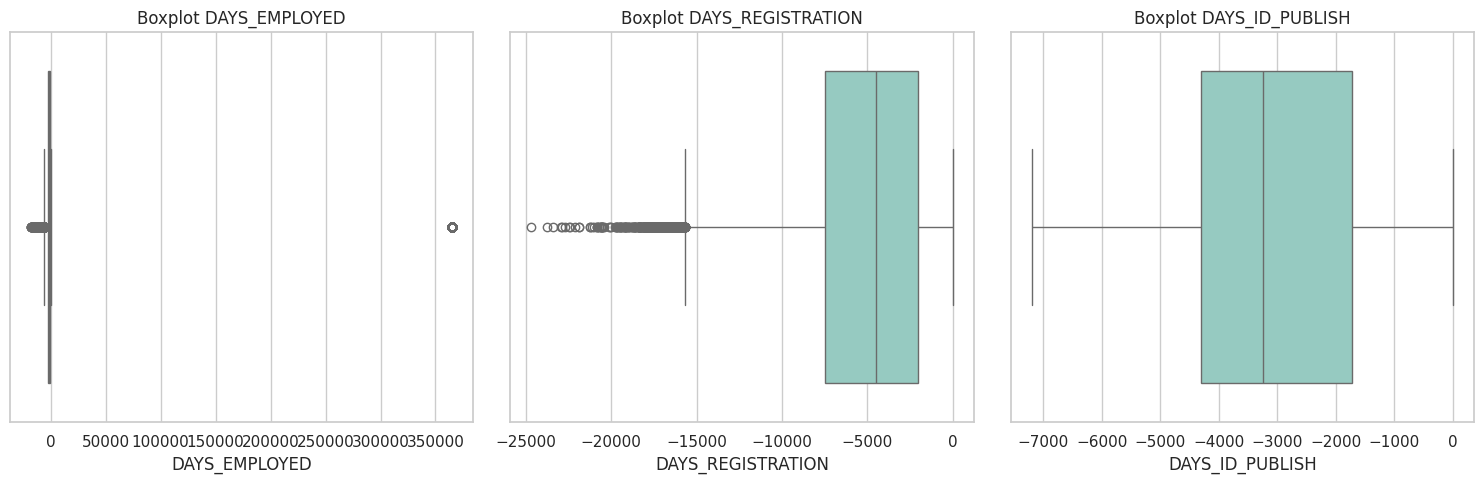

In [19]:
columns = ['DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(columns):
    # ax = axes[i // 3, i % 3]
    ax = axes[i]
    sns.boxplot(x=df1[col], ax=ax)  
    ax.set_title(f'Boxplot {col}') 

plt.tight_layout()  
plt.show()

In [20]:
df1['DAYS_EMPLOYED'].isnull().sum()

0

## **c. Preprocessing** 

In [21]:
df1['DAYS_BIRTH'] = -df1['DAYS_BIRTH'] / 365

In [22]:
df1['DAYS_BIRTH']

0         25.920548
1         45.931507
2         52.180822
3         52.068493
4         54.608219
            ...    
307506    25.553425
307507    56.917808
307508    41.002740
307509    32.769863
307510    46.180822
Name: DAYS_BIRTH, Length: 307511, dtype: float64

<Axes: xlabel='DAYS_BIRTH', ylabel='Count'>

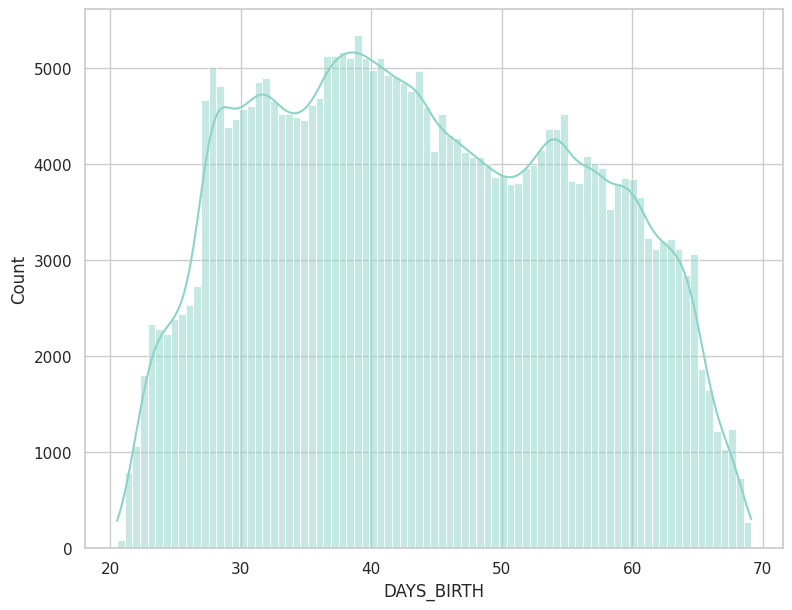

In [23]:
sns.histplot(x=df1['DAYS_BIRTH'],kde=True)


In [24]:
label_encoder = LabelEncoder()
for col in categorical_cols:
    df1[col] = label_encoder.fit_transform(df1[col])
df1[categorical_cols].head()

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0                   0            1             0                1   
1                   0            0             0                0   
2                   1            1             1                1   
3                   0            0             0                1   
4                   0            1             0                1   

   NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                6                 7                    4                   3   
1                1                 4                    1                   1   
2                6                 7                    4                   3   
3                6                 7                    4                   0   
4                6                 7                    4                   3   

   NAME_HOUSING_TYPE  OCCUPATION_TYPE  WEEKDAY_APPR_PROCESS_START  \
0                  1                8                           6   
1                  1                3                           1   
2                  1                8                           1   
3                  1                8                           6   
4                  1                3                           4   

   ORGANIZATION_TYPE  FONDKAPREMONT_MODE  HOUSETYPE_MODE  WALLSMATERIAL_MODE  \
0                  5                   2               0                   5   
1                 39                   2               0                   0   
2                 11                   4               3                   7   
3                  5                   4               3                   7   
4                 37                   4               3                   7   

   EMERGENCYSTATE_MODE  
0                    0  
1                    0  
2                    2  
3                    2  
4                    2

In [25]:
df1['TARGET'].unique()

array([1, 0])

In [26]:
# missing value
find_missing(df1).sort_values(['missing_ratio'], ascending=False).head(20)

column name  missing_ratio
76           COMMONAREA_MEDI      69.872297
62           COMMONAREA_MODE      69.872297
48            COMMONAREA_AVG      69.872297
84  NONLIVINGAPARTMENTS_MEDI      69.432963
70  NONLIVINGAPARTMENTS_MODE      69.432963
56   NONLIVINGAPARTMENTS_AVG      69.432963
82     LIVINGAPARTMENTS_MEDI      68.354953
68     LIVINGAPARTMENTS_MODE      68.354953
54      LIVINGAPARTMENTS_AVG      68.354953
80            FLOORSMIN_MEDI      67.848630
52             FLOORSMIN_AVG      67.848630
66            FLOORSMIN_MODE      67.848630
47           YEARS_BUILD_AVG      66.497784
61          YEARS_BUILD_MODE      66.497784
75          YEARS_BUILD_MEDI      66.497784
21               OWN_CAR_AGE      65.990810
81             LANDAREA_MEDI      59.376738
67             LANDAREA_MODE      59.376738
53              LANDAREA_AVG      59.376738
73         BASEMENTAREA_MEDI      58.515956

In [27]:
numerical_cols_with_na = [col for col in numerical_cols if df1[col].isnull().any()]

for col in numerical_cols_with_na:
    median_value = df1[col].median()
    df1[col] = df1[col].fillna(median_value) 


In [28]:
df1[numerical_cols_with_na].isnull().sum()

AMT_ANNUITY                   0
AMT_GOODS_PRICE               0
OWN_CAR_AGE                   0
CNT_FAM_MEMBERS               0
EXT_SOURCE_1                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 61, dtype: int64

In [29]:
outliers = {}

for col in numerical_cols:
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = df1[(df1[col] < lower_bound) | (df1[col] > upper_bound)].shape[0]

outliers_df = pd.DataFrame(outliers.items(), columns=['Column', 'Outliers Count'])
outliers_df = outliers_df.sort_values(by='Outliers Count', ascending=True)
outliers_df.head(40)

Column  Outliers Count
0                     SK_ID_CURR               0
11               DAYS_ID_PUBLISH               0
17                    FLAG_PHONE               0
30                  EXT_SOURCE_2               0
8                     DAYS_BIRTH               0
81               FLAG_DOCUMENT_3               0
13                    FLAG_MOBIL               1
90              FLAG_DOCUMENT_12               2
88              FLAG_DOCUMENT_10               7
80               FLAG_DOCUMENT_2              13
82               FLAG_DOCUMENT_4              25
85               FLAG_DOCUMENT_7              59
95              FLAG_DOCUMENT_17              82
99              FLAG_DOCUMENT_21             103
98              FLAG_DOCUMENT_20             156
97              FLAG_DOCUMENT_19             183
93              FLAG_DOCUMENT_15             372
79        DAYS_LAST_PHONE_CHANGE             435
16              FLAG_CONT_MOBILE             574
10             DAYS_REGISTRATION             659
92              FLAG_DOCUMENT_14             903
91              FLAG_DOCUMENT_13            1084
87               FLAG_DOCUMENT_9            1198
89              FLAG_DOCUMENT_11            1203
101    AMT_REQ_CREDIT_BUREAU_DAY            1489
100   AMT_REQ_CREDIT_BUREAU_HOUR            1626
22       HOUR_APPR_PROCESS_START            2257
96              FLAG_DOCUMENT_18            2500
94              FLAG_DOCUMENT_16            3053
19               CNT_FAM_MEMBERS            4007
2                   CNT_CHILDREN            4272
31                  EXT_SOURCE_3            4313
83               FLAG_DOCUMENT_5            4648
23    REG_REGION_NOT_LIVE_REGION            4657
4                     AMT_CREDIT            6562
105   AMT_REQ_CREDIT_BUREAU_YEAR            7233
5                    AMT_ANNUITY            7504
7     REGION_POPULATION_RELATIVE            8412
102   AMT_REQ_CREDIT_BUREAU_WEEK            8536
25   LIVE_REGION_NOT_WORK_REGION           12503

<Axes: xlabel='DAYS_EMPLOYED'>

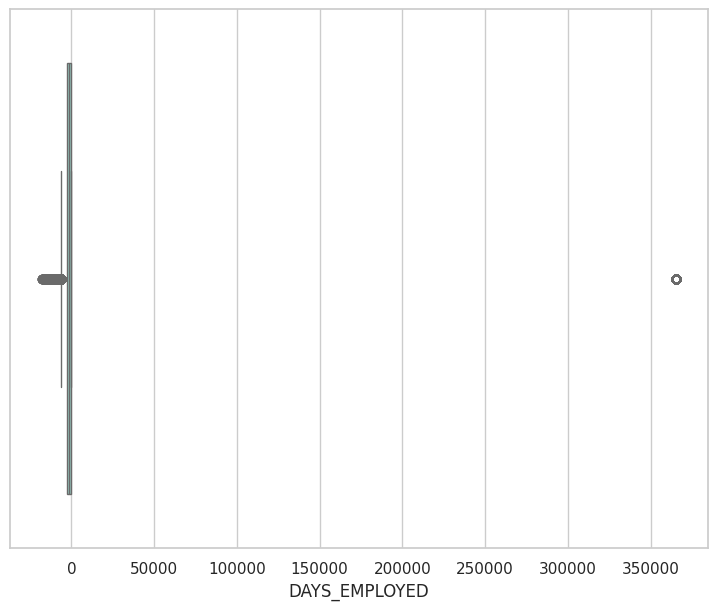

In [30]:
sns.boxplot(x=df1['DAYS_EMPLOYED'])

In [31]:
print(zero_proportion[(zero_proportion > 0.5)])

FLAG_DOCUMENT_12               0.999993
FLAG_DOCUMENT_10               0.999977
FLAG_DOCUMENT_2                0.999958
FLAG_DOCUMENT_4                0.999919
FLAG_DOCUMENT_7                0.999808
FLAG_DOCUMENT_17               0.999733
FLAG_DOCUMENT_21               0.999665
FLAG_DOCUMENT_20               0.999493
FLAG_DOCUMENT_19               0.999405
FLAG_DOCUMENT_15               0.998790
FLAG_DOCUMENT_14               0.997064
FLAG_DOCUMENT_13               0.996475
FLAG_DOCUMENT_9                0.996104
FLAG_DOCUMENT_11               0.996088
FLAG_DOCUMENT_18               0.991870
FLAG_DOCUMENT_16               0.990072
FLAG_DOCUMENT_5                0.984885
REG_REGION_NOT_LIVE_REGION     0.984856
LIVE_REGION_NOT_WORK_REGION    0.959341
REG_REGION_NOT_WORK_REGION     0.949231
FLAG_EMAIL                     0.943280
REG_CITY_NOT_LIVE_CITY         0.921827
TARGET                         0.919271
FLAG_DOCUMENT_8                0.918624
DEF_60_CNT_SOCIAL_CIRCLE       0.912881


In [32]:
df1.isnull().sum()

SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 122, dtype: int64

In [33]:
df1['DAYS_EMPLOYED']

0           -637
1          -1188
2           -225
3          -3039
4          -3038
           ...  
307506      -236
307507    365243
307508     -7921
307509     -4786
307510     -1262
Name: DAYS_EMPLOYED, Length: 307511, dtype: int64

<Axes: xlabel='DAYS_EMPLOYED', ylabel='Count'>

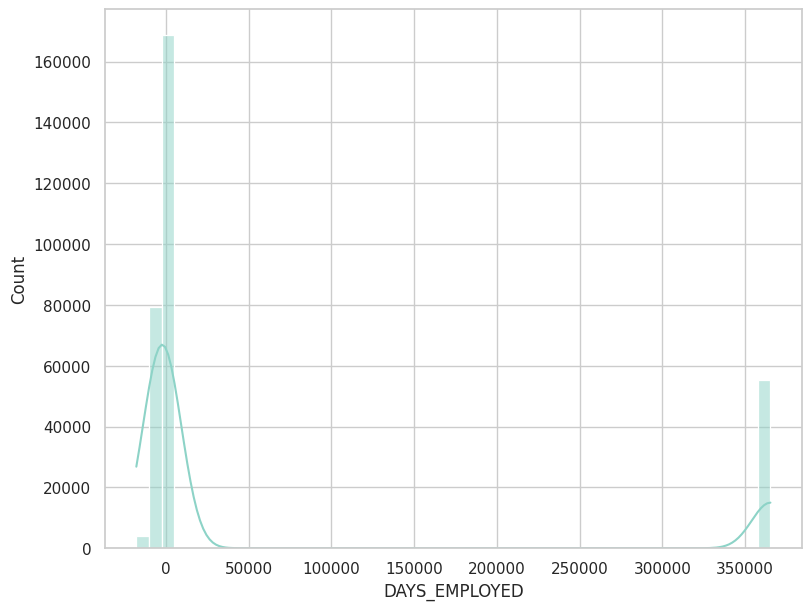

In [34]:
sns.histplot(df1['DAYS_EMPLOYED'], bins=50, kde=True)

In [35]:
median_value = df1['DAYS_EMPLOYED'].median()

# Ganti nilai outlier (misalnya lebih dari 3 standar deviasi) dengan nilai median
df1['DAYS_EMPLOYED'] = df1['DAYS_EMPLOYED'].apply(lambda x: median_value if abs(x) > 10000 else x)
df1['DAYS_EMPLOYED']

0         -637.0
1        -1188.0
2         -225.0
3        -3039.0
4        -3038.0
           ...  
307506    -236.0
307507   -1213.0
307508   -7921.0
307509   -4786.0
307510   -1262.0
Name: DAYS_EMPLOYED, Length: 307511, dtype: float64

In [36]:
correlation_with_target=df1.corr()['TARGET'].sort_values(ascending=False)
correlation_with_target.head(55)

TARGET                          1.000000
REGION_RATING_CLIENT_W_CITY     0.060893
REGION_RATING_CLIENT            0.058899
DAYS_EMPLOYED                   0.055990
DAYS_LAST_PHONE_CHANGE          0.055218
CODE_GENDER                     0.054713
NAME_EDUCATION_TYPE             0.054699
DAYS_ID_PUBLISH                 0.051457
REG_CITY_NOT_WORK_CITY          0.050994
NAME_INCOME_TYPE                0.046829
FLAG_EMP_PHONE                  0.045982
REG_CITY_NOT_LIVE_CITY          0.044395
FLAG_DOCUMENT_3                 0.044346
DAYS_REGISTRATION               0.041975
EMERGENCYSTATE_MODE             0.041955
HOUSETYPE_MODE                  0.040211
WALLSMATERIAL_MODE              0.037076
NAME_HOUSING_TYPE               0.034489
LIVE_CITY_NOT_WORK_CITY         0.032518
DEF_30_CNT_SOCIAL_CIRCLE        0.032394
DEF_60_CNT_SOCIAL_CIRCLE        0.031401
FLAG_WORK_PHONE                 0.028524
FONDKAPREMONT_MODE              0.026924
CNT_CHILDREN                    0.019187
OWN_CAR_AGE     

In [37]:
low_corr_cols = correlation_with_target[correlation_with_target.abs() < 0.01]
low_corr_cols_list=low_corr_cols.index.tolist()

In [38]:
zero_prop=zero_proportion[(zero_proportion > 0.99)]
high_zero=zero_prop.index.tolist()

In [39]:
drop_cols = set(low_corr_cols_list).intersection(high_zero)


In [40]:
drop_cols

{'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_9'}

In [41]:
df1_drop = df1.drop(columns=drop_cols)

In [42]:
df1_drop

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0           100002       1                   0            1             0   
1           100003       0                   0            0             0   
2           100004       0                   1            1             1   
3           100006       0                   0            0             0   
4           100007       0                   0            1             0   
...            ...     ...                 ...          ...           ...   
307506      456251       0                   0            1             0   
307507      456252       0                   0            0             0   
307508      456253       0                   0            0             0   
307509      456254       1                   0            0             0   
307510      456255       0                   0            0             0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                     1             0          202500.0    406597.5   
1                     0             0          270000.0   1293502.5   
2                     1             0           67500.0    135000.0   
3                     1             0          135000.0    312682.5   
4                     1             0          121500.0    513000.0   
...                 ...           ...               ...         ...   
307506                0             0          157500.0    254700.0   
307507                1             0           72000.0    269550.0   
307508                1             0          153000.0    677664.0   
307509                1             0          171000.0    370107.0   
307510                0             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_6  FLAG_DOCUMENT_8  FLAG_DOCUMENT_13  \
0           24700.5  ...                0                0                 0   
1           35698.5  ...                0                0                 0   
2            6750.0  ...                0                0                 0   
3           29686.5  ...                0                0                 0   
4           21865.5  ...                0                1                 0   
...             ...  ...              ...              ...               ...   
307506      27558.0  ...                0                1                 0   
307507      12001.5  ...                0                0                 0   
307508      29979.0  ...                0                0                 0   
307509      20205.0  ...                0                0                 0   
307510      49117.5  ...                0                0                 0   

        FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                      0                         0.0   
1                      0                         0.0   
2                      0                         0.0   
3                      0                         0.0   
4                      0                         0.0   
...                  ...                         ...   
307506                 0                         0.0   
307507                 0                         0.0   
307508                 0                         1.0   
307509                 0                         0.0   
307510                 0                         0.0   

        AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                             0.0                         0.0   
1                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
...                           ...                         ...   
307506                        0.0                         0.0   
307507                        0.0                         0.0   
307508     

In [43]:
df1_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 108 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(67), int64(41)
memory usage: 253.4 MB


# **2. Previous Application**

Melakukan langkah yang sama pada dataset ini.

## **a. Load Dataset** 

In [44]:
df2 = pd.read_csv("/kaggle/input/home-credit-default-risk/previous_application.csv")
df2.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

In [45]:
df2.shape

(1670214, 37)

## **b. Exploratory Data Analysis** 

In [46]:
categorical_cols1 = df2.select_dtypes(include=['object', 'category']).columns
categorical_cols_df1 = pd.DataFrame(categorical_cols1, columns=['Categorical Columns'])
print(categorical_cols_df1)

            Categorical Columns
0            NAME_CONTRACT_TYPE
1    WEEKDAY_APPR_PROCESS_START
2   FLAG_LAST_APPL_PER_CONTRACT
3        NAME_CASH_LOAN_PURPOSE
4          NAME_CONTRACT_STATUS
5             NAME_PAYMENT_TYPE
6            CODE_REJECT_REASON
7               NAME_TYPE_SUITE
8              NAME_CLIENT_TYPE
9           NAME_GOODS_CATEGORY
10               NAME_PORTFOLIO
11            NAME_PRODUCT_TYPE
12                 CHANNEL_TYPE
13         NAME_SELLER_INDUSTRY
14             NAME_YIELD_GROUP
15          PRODUCT_COMBINATION


In [47]:
numerical_cols1 = df2.select_dtypes(include=['integer', 'float']).columns
numerical_cols_df1 = pd.DataFrame(numerical_cols1, columns=['Numerical Columns'])
print(numerical_cols_df1)

            Numerical Columns
0                  SK_ID_PREV
1                  SK_ID_CURR
2                 AMT_ANNUITY
3             AMT_APPLICATION
4                  AMT_CREDIT
5            AMT_DOWN_PAYMENT
6             AMT_GOODS_PRICE
7     HOUR_APPR_PROCESS_START
8      NFLAG_LAST_APPL_IN_DAY
9           RATE_DOWN_PAYMENT
10      RATE_INTEREST_PRIMARY
11   RATE_INTEREST_PRIVILEGED
12              DAYS_DECISION
13           SELLERPLACE_AREA
14                CNT_PAYMENT
15         DAYS_FIRST_DRAWING
16             DAYS_FIRST_DUE
17  DAYS_LAST_DUE_1ST_VERSION
18              DAYS_LAST_DUE
19           DAYS_TERMINATION
20  NFLAG_INSURED_ON_APPROVAL


In [48]:
find_missing(df2).sort_values(['missing_ratio'], ascending=False).head(20)

column name  missing_ratio
14   RATE_INTEREST_PRIVILEGED      99.643698
13      RATE_INTEREST_PRIMARY      99.643698
6            AMT_DOWN_PAYMENT      53.636480
12          RATE_DOWN_PAYMENT      53.636480
20            NAME_TYPE_SUITE      49.119754
35           DAYS_TERMINATION      40.298129
31         DAYS_FIRST_DRAWING      40.298129
32             DAYS_FIRST_DUE      40.298129
33  DAYS_LAST_DUE_1ST_VERSION      40.298129
34              DAYS_LAST_DUE      40.298129
36  NFLAG_INSURED_ON_APPROVAL      40.298129
7             AMT_GOODS_PRICE      23.081773
3                 AMT_ANNUITY      22.286665
28                CNT_PAYMENT      22.286366
30        PRODUCT_COMBINATION       0.020716
5                  AMT_CREDIT       0.000060
0                  SK_ID_PREV       0.000000
4             AMT_APPLICATION       0.000000
2          NAME_CONTRACT_TYPE       0.000000
1                  SK_ID_CURR       0.000000

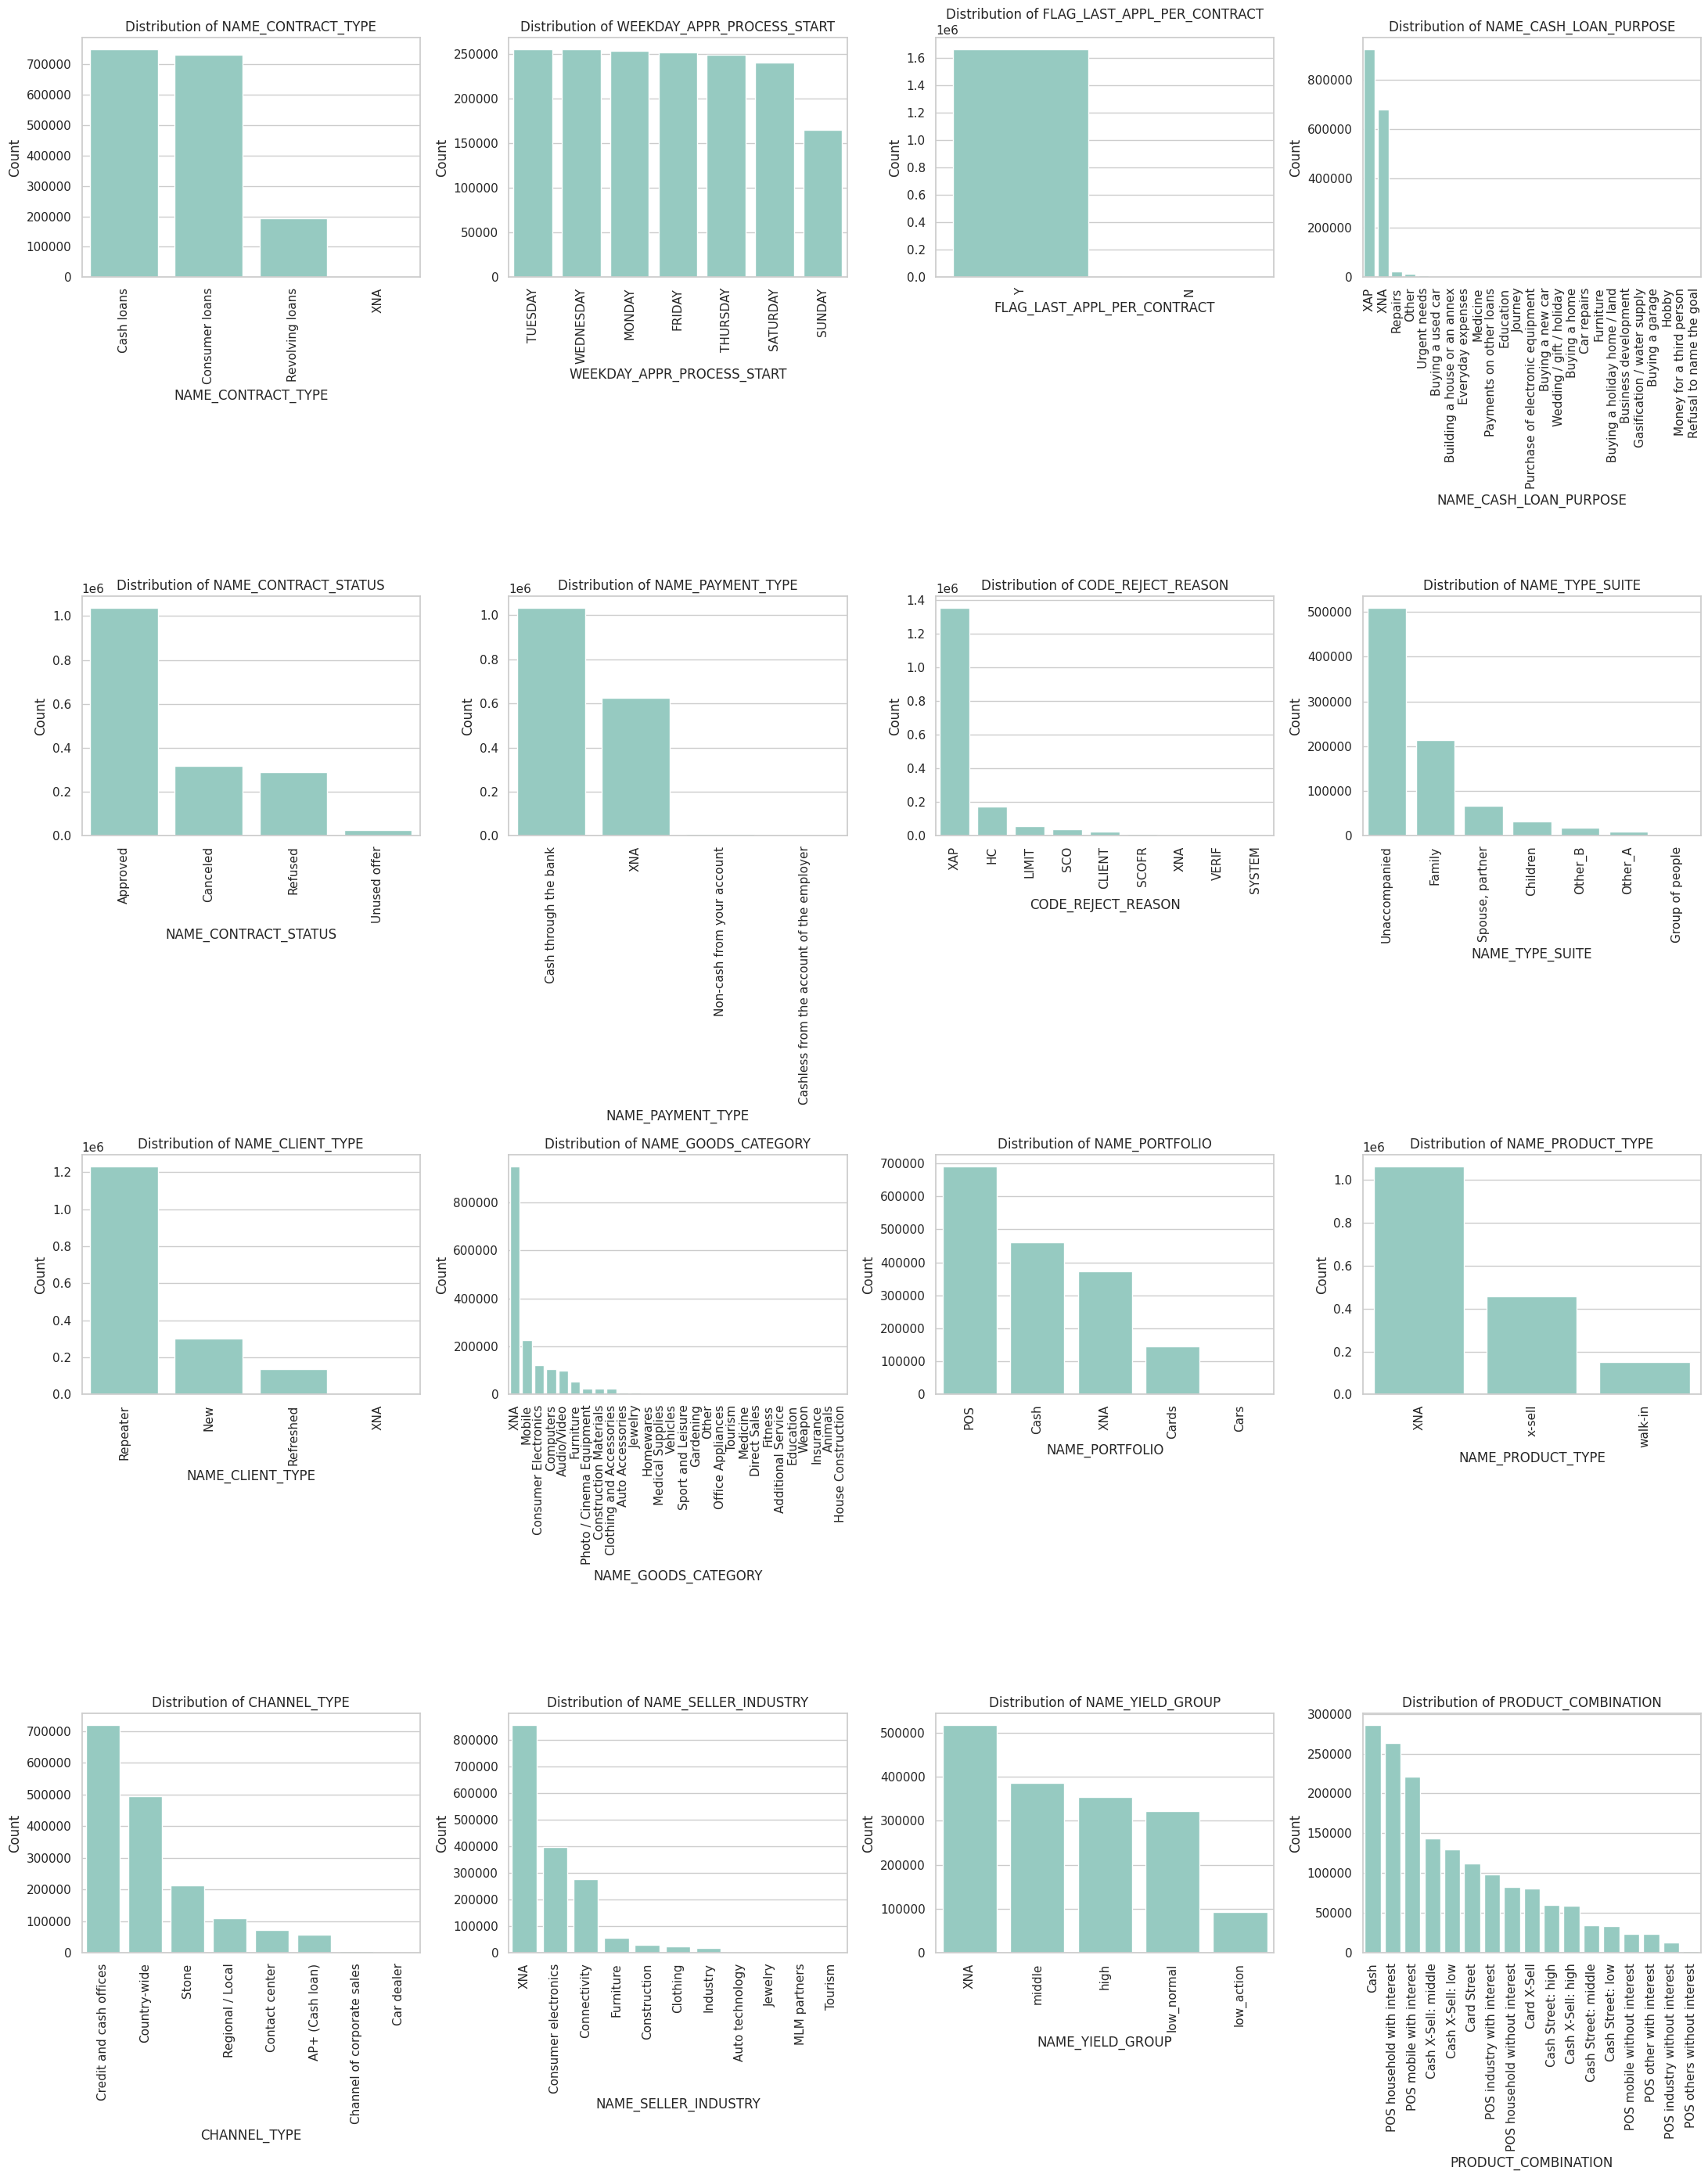

In [49]:
n_cols = 4 
n_rows = -(-len(categorical_cols1) // n_cols) 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 7* n_rows))  
axes = axes.flatten()  

for i, col in enumerate(categorical_cols1):
    value_counts = df2[col].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

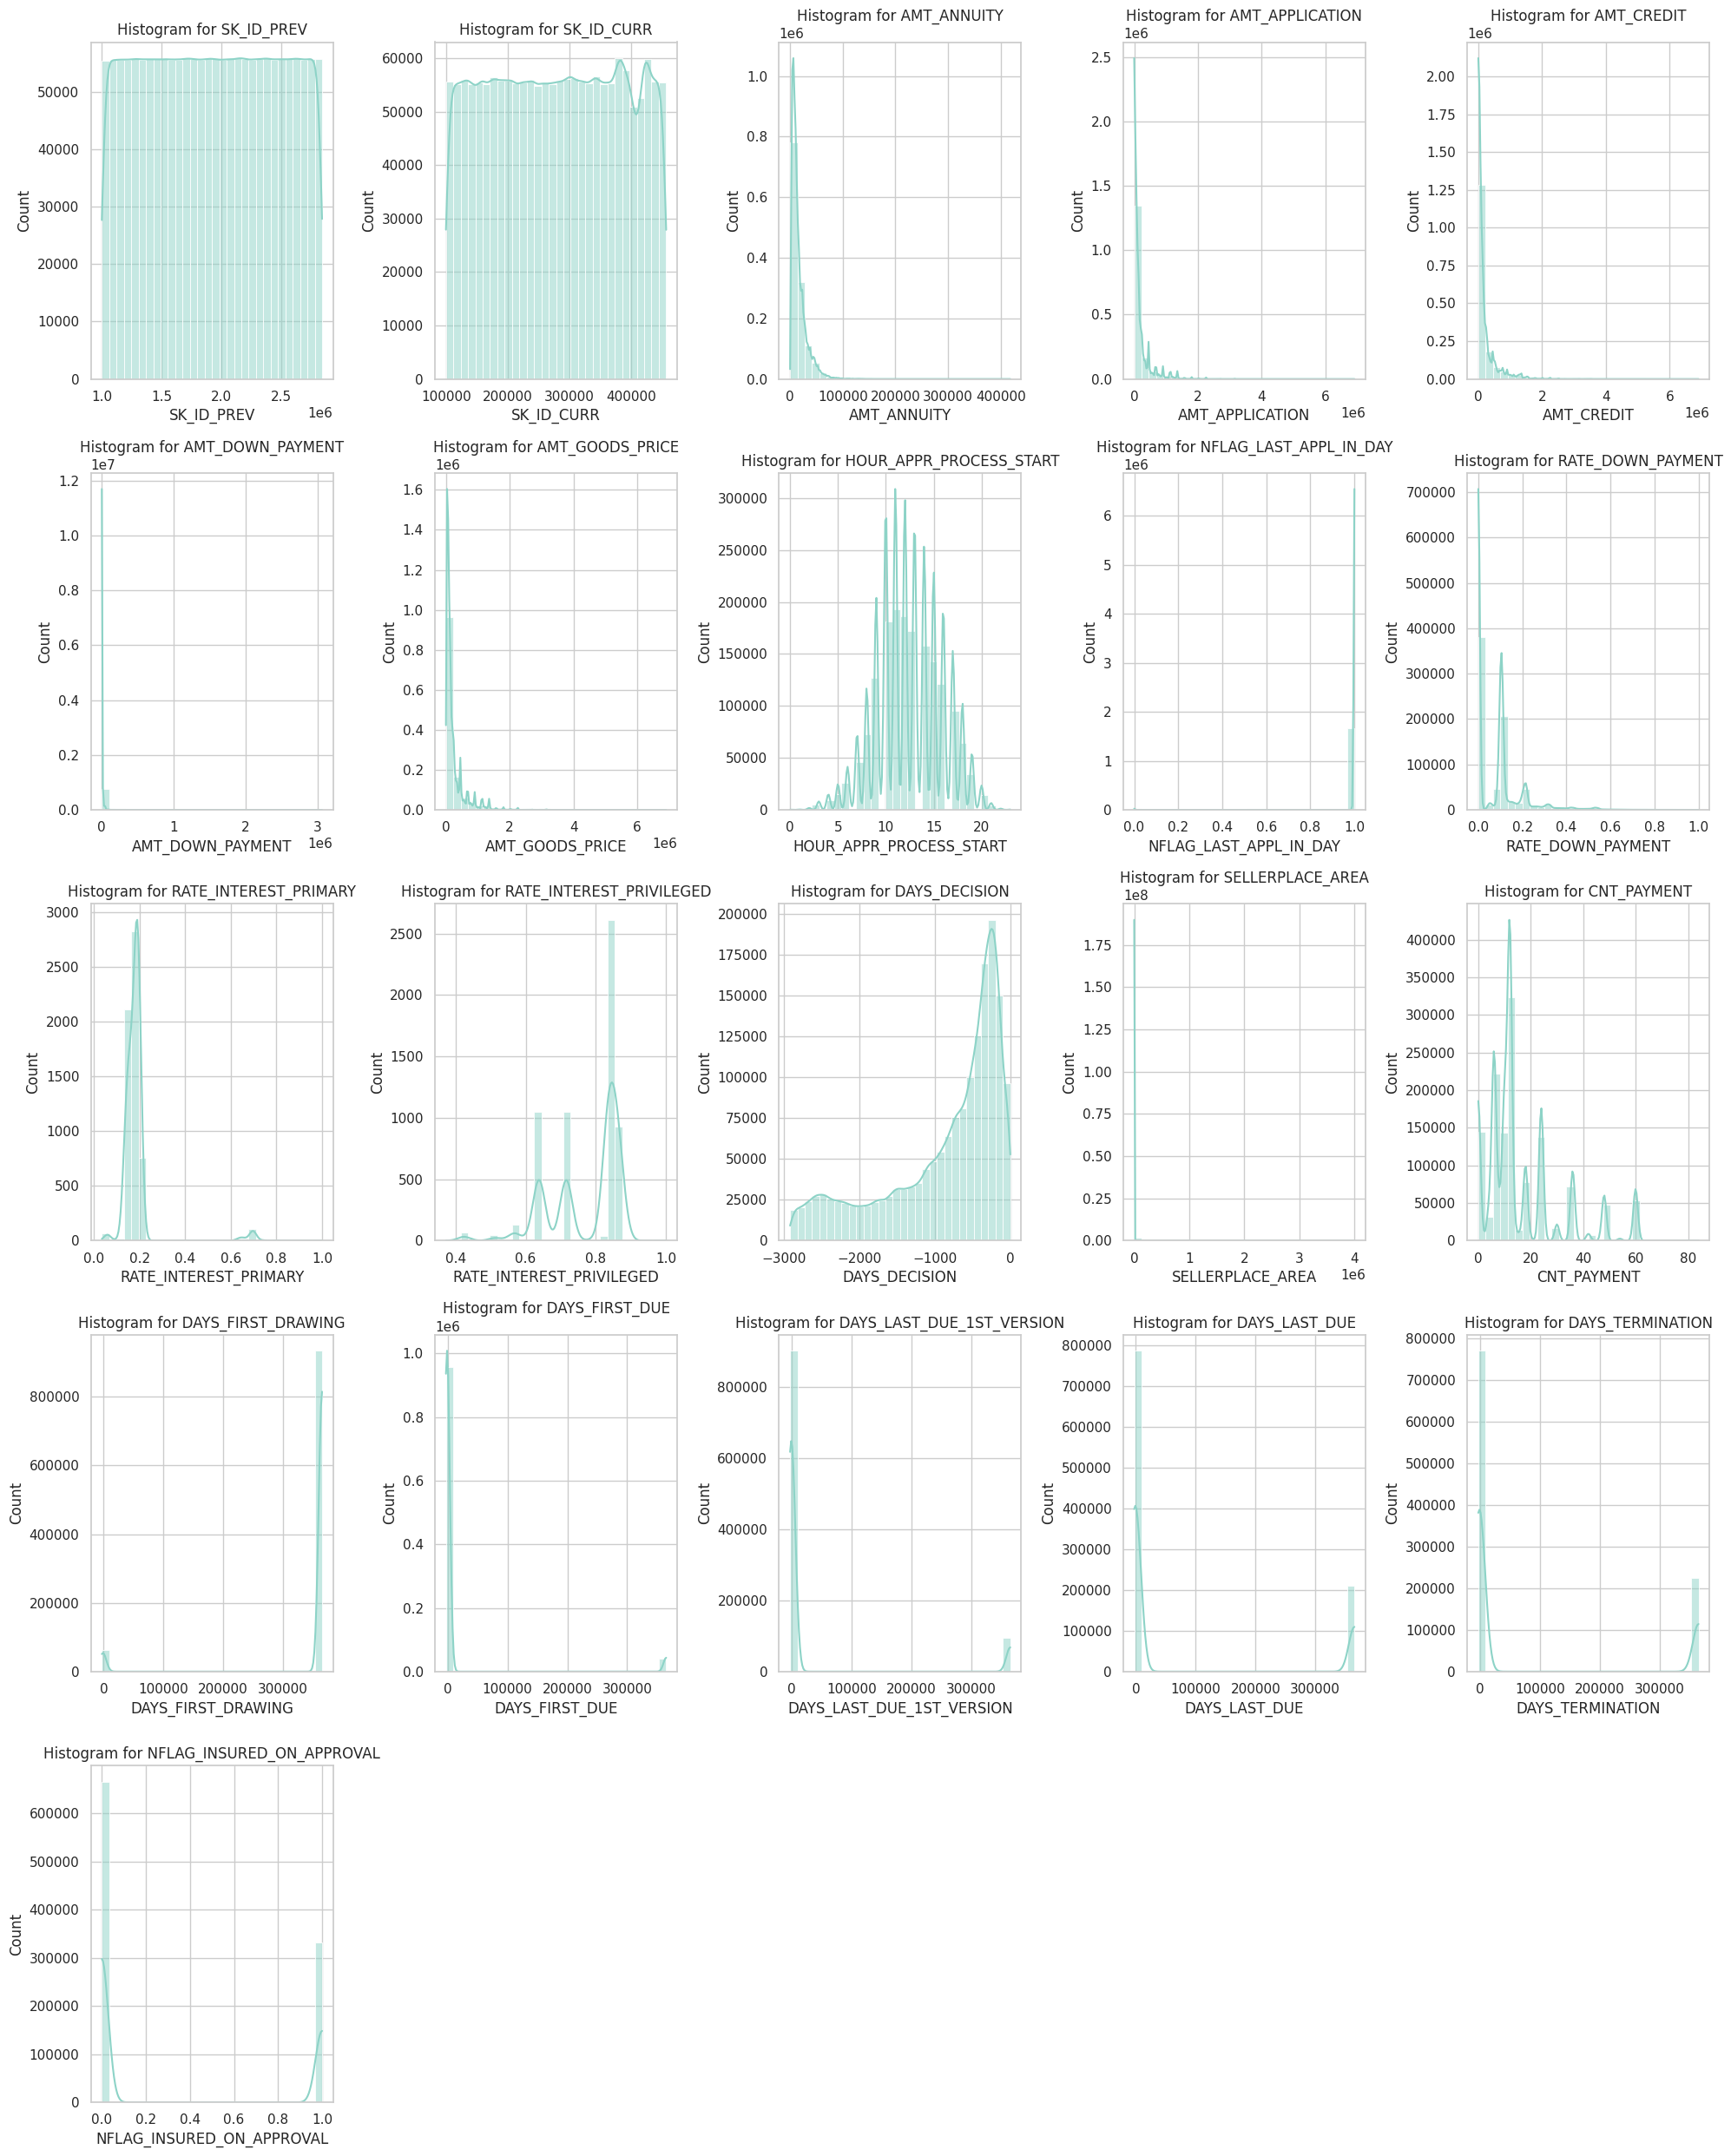

In [50]:
n_cols = 5
n_rows = -(-len(numerical_cols1) // n_cols)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()  

for i, column in enumerate(numerical_cols1) :
    sns.histplot(data=df2, x=column, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Histogram for {column}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## **c. Preprocessing data** 

In [51]:
# handling unknown categorical data using mode
mode_name_contract = df2['NAME_CONTRACT_TYPE'].mode()[0]
df2['NAME_CONTRACT_TYPE'] = df2['NAME_CONTRACT_TYPE'].replace('XNA', mode_name_contract )

mode_name_client = df2['NAME_CLIENT_TYPE'].mode()[0]
df2['NAME_CLIENT_TYPE'] = df2['NAME_CLIENT_TYPE'].replace('Unknown', mode_name_client)

In [52]:
from sklearn.preprocessing import LabelEncoder
label_encoder1 = LabelEncoder()
for col in categorical_cols1:
    df2[col] = label_encoder1.fit_transform(df2[col])
df2[categorical_cols1].head()

NAME_CONTRACT_TYPE  WEEKDAY_APPR_PROCESS_START  \
0                   1                           2   
1                   0                           4   
2                   0                           5   
3                   0                           1   
4                   0                           4   

   FLAG_LAST_APPL_PER_CONTRACT  NAME_CASH_LOAN_PURPOSE  NAME_CONTRACT_STATUS  \
0                            1                      23                     0   
1                            1                      24                     0   
2                            1                      24                     0   
3                            1                      24                     0   
4                            1                      20                     2   

   NAME_PAYMENT_TYPE  CODE_REJECT_REASON  NAME_TYPE_SUITE  NAME_CLIENT_TYPE  \
0                  0                   7                7                 2   
1                  3                   7                6                 2   
2                  0                   7                5                 2   
3                  0                   7                7                 2   
4                  0                   1                7                 2   

   NAME_GOODS_CATEGORY  NAME_PORTFOLIO  NAME_PRODUCT_TYPE  CHANNEL_TYPE  \
0                   19               3                  0             4   
1                   27               2                  2             3   
2                   27               2                  2             5   
3                   27               2                  2             5   
4                   27               2                  1             5   

   NAME_SELLER_INDUSTRY  NAME_YIELD_GROUP  PRODUCT_COMBINATION  
0                     2                 4                   13  
1                    10                 2                    7  
2                    10                 1                    6  
3                    10                 4                    8  
4                    10                 1                    3

In [53]:
df2.drop(columns=['RATE_INTEREST_PRIVILEGED','RATE_INTEREST_PRIMARY'], inplace=True)

In [54]:
# handling missing value
exclude_cols = ['RATE_INTEREST_PRIVILEGED','RATE_INTEREST_PRIMARY']  
# Loop hanya untuk kolom numerikal yang tidak termasuk dalam exclude_cols
for col in numerical_cols1:
    if col not in exclude_cols:
        median_value = df2[col].median()
        df2[col] = df2[col].fillna(median_value) 

In [55]:
df2.isnull().sum()

SK_ID_PREV                     0
SK_ID_CURR                     0
NAME_CONTRACT_TYPE             0
AMT_ANNUITY                    0
AMT_APPLICATION                0
AMT_CREDIT                     0
AMT_DOWN_PAYMENT               0
AMT_GOODS_PRICE                0
WEEKDAY_APPR_PROCESS_START     0
HOUR_APPR_PROCESS_START        0
FLAG_LAST_APPL_PER_CONTRACT    0
NFLAG_LAST_APPL_IN_DAY         0
RATE_DOWN_PAYMENT              0
NAME_CASH_LOAN_PURPOSE         0
NAME_CONTRACT_STATUS           0
DAYS_DECISION                  0
NAME_PAYMENT_TYPE              0
CODE_REJECT_REASON             0
NAME_TYPE_SUITE                0
NAME_CLIENT_TYPE               0
NAME_GOODS_CATEGORY            0
NAME_PORTFOLIO                 0
NAME_PRODUCT_TYPE              0
CHANNEL_TYPE                   0
SELLERPLACE_AREA               0
NAME_SELLER_INDUSTRY           0
CNT_PAYMENT                    0
NAME_YIELD_GROUP               0
PRODUCT_COMBINATION            0
DAYS_FIRST_DRAWING             0
DAYS_FIRST

In [56]:
df2['DAYS_TERMINATION'].describe().T

count    1.670214e+06
mean     4.874988e+04
std      1.251729e+05
min     -2.874000e+03
25%     -6.950000e+02
50%     -4.990000e+02
75%     -3.340000e+02
max      3.652430e+05
Name: DAYS_TERMINATION, dtype: float64

<Axes: xlabel='DAYS_LAST_DUE', ylabel='Count'>

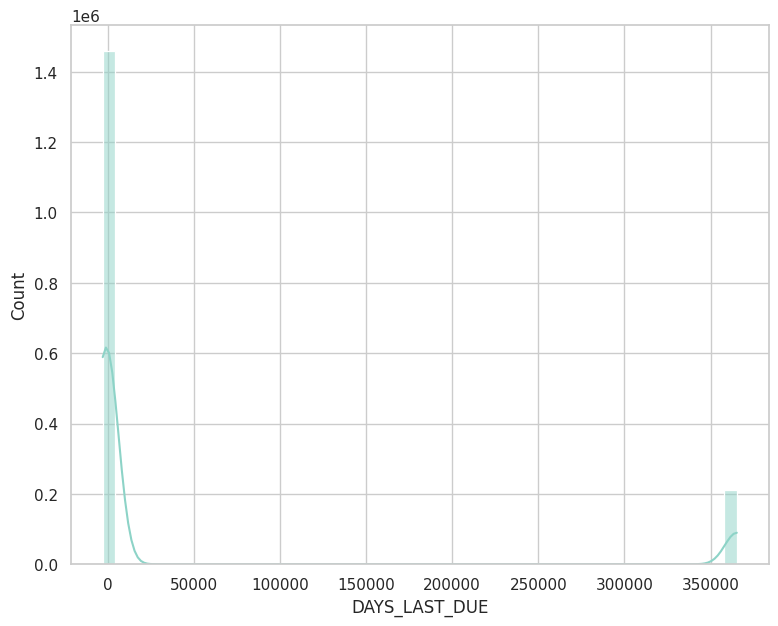

In [57]:
sns.histplot(df2['DAYS_LAST_DUE'], bins=50, kde=True)

In [58]:
# Daftar kolom yang ingin diproses
columns_to_fix = [
    'DAYS_FIRST_DRAWING',
    'DAYS_FIRST_DUE',
    'DAYS_LAST_DUE_1ST_VERSION',
    'DAYS_LAST_DUE',
    'DAYS_TERMINATION']

for col in columns_to_fix:
    median_value = df2[col].median()
    df2[col] = df2[col].apply(lambda x: median_value if x == 3.652430e+05 else x)

In [59]:
df2['DAYS_TERMINATION'].describe().T

count    1.670214e+06
mean    -7.203557e+02
std      5.623646e+02
min     -2.874000e+03
25%     -6.950000e+02
50%     -4.990000e+02
75%     -4.990000e+02
max     -2.000000e+00
Name: DAYS_TERMINATION, dtype: float64

In [60]:
# sns.boxplot(x=df2['HOUR_APPR_PROCESS_START'])

In [61]:
df2.shape

(1670214, 35)

In [62]:
df2.isnull().sum()

SK_ID_PREV                     0
SK_ID_CURR                     0
NAME_CONTRACT_TYPE             0
AMT_ANNUITY                    0
AMT_APPLICATION                0
AMT_CREDIT                     0
AMT_DOWN_PAYMENT               0
AMT_GOODS_PRICE                0
WEEKDAY_APPR_PROCESS_START     0
HOUR_APPR_PROCESS_START        0
FLAG_LAST_APPL_PER_CONTRACT    0
NFLAG_LAST_APPL_IN_DAY         0
RATE_DOWN_PAYMENT              0
NAME_CASH_LOAN_PURPOSE         0
NAME_CONTRACT_STATUS           0
DAYS_DECISION                  0
NAME_PAYMENT_TYPE              0
CODE_REJECT_REASON             0
NAME_TYPE_SUITE                0
NAME_CLIENT_TYPE               0
NAME_GOODS_CATEGORY            0
NAME_PORTFOLIO                 0
NAME_PRODUCT_TYPE              0
CHANNEL_TYPE                   0
SELLERPLACE_AREA               0
NAME_SELLER_INDUSTRY           0
CNT_PAYMENT                    0
NAME_YIELD_GROUP               0
PRODUCT_COMBINATION            0
DAYS_FIRST_DRAWING             0
DAYS_FIRST

# **3. Joining**

In [63]:
df1_drop.shape

(307511, 108)

In [64]:
df1_drop['SK_ID_CURR'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 307511 entries, 0 to 307510
Series name: SK_ID_CURR
Non-Null Count   Dtype
--------------   -----
307511 non-null  int64
dtypes: int64(1)
memory usage: 2.3 MB


In [65]:
from datetime import datetime

start = datetime.now()
columns_to_aggregate = df2.drop(['SK_ID_CURR'], axis=1).columns
aggregated_data = df2.groupby('SK_ID_CURR')[columns_to_aggregate].mean().reset_index()
df = pd.merge(df1_drop, aggregated_data, on='SK_ID_CURR', how='left')
print("Time taken to run this cell:", datetime.now() - start)
df.head()


Time taken to run this cell: 0:00:01.723190


SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE_x  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                     0            1             0   
1      100003       0                     0            0             0   
2      100004       0                     1            1             1   
3      100006       0                     0            0             0   
4      100007       0                     0            1             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
0                1             0          202500.0      406597.5   
1                0             0          270000.0     1293502.5   
2                1             0           67500.0      135000.0   
3                1             0          135000.0      312682.5   
4                1             0          121500.0      513000.0   

   AMT_ANNUITY_x  ...  NAME_SELLER_INDUSTRY  CNT_PAYMENT  NAME_YIELD_GROUP  \
0        24700.5  ...              0.000000    24.000000          3.000000   
1        35698.5  ...              6.333333    10.000000          3.666667   
2         6750.0  ...              2.000000     4.000000          4.000000   
3        29686.5  ...              8.555556    19.333333          1.333333   
4        21865.5  ...              5.666667    20.666667          2.500000   

   PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  \
0            15.000000            365243.0     -565.000000   
1             9.000000            365243.0    -1274.333333   
2            14.000000            365243.0     -784.000000   
3             5.000000            365243.0     -662.555556   
4             8.166667            365243.0    -1191.166667   

   DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
0                 125.000000     -25.000000        -17.000000   
1               -1004.333333   -1054.333333      -1047.333333   
2                -694.000000    -724.000000       -714.000000   
3                -119.222222    -481.666667       -450.222222   
4                -757.833333    -939.333333       -920.333333   

   NFLAG_INSURED_ON_APPROVAL  
0                   0.000000  
1                   0.666667  
2                   0.000000  
3                   0.000000  
4                   0.500000  

[5 rows x 142 columns]

In [66]:
# # Agregasi df2 untuk menangani duplikasi SK_ID_CURR

# df = pd.merge(df1, df2_agg, on='SK_ID_CURR', how='left')
# df

In [67]:
df['TARGET'].unique()

array([1, 0])

# **4. Classification**

In [68]:
df.isnull().sum()

SK_ID_CURR                       0
TARGET                           0
NAME_CONTRACT_TYPE_x             0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
                             ...  
DAYS_FIRST_DUE               16454
DAYS_LAST_DUE_1ST_VERSION    16454
DAYS_LAST_DUE                16454
DAYS_TERMINATION             16454
NFLAG_INSURED_ON_APPROVAL    16454
Length: 142, dtype: int64

In [69]:
df.fillna(df.median(), inplace=True)

In [70]:
df.isnull().sum()

SK_ID_CURR                   0
TARGET                       0
NAME_CONTRACT_TYPE_x         0
CODE_GENDER                  0
FLAG_OWN_CAR                 0
                            ..
DAYS_FIRST_DUE               0
DAYS_LAST_DUE_1ST_VERSION    0
DAYS_LAST_DUE                0
DAYS_TERMINATION             0
NFLAG_INSURED_ON_APPROVAL    0
Length: 142, dtype: int64

In [71]:
correlation_with_target = df.corr()['TARGET'].sort_values(ascending=False)
print(correlation_with_target)

TARGET                         1.000000
NAME_CONTRACT_STATUS           0.069421
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_EMPLOYED                  0.055990
                                 ...   
CODE_REJECT_REASON            -0.068995
DAYS_BIRTH                    -0.078239
EXT_SOURCE_1                  -0.098887
EXT_SOURCE_3                  -0.155892
EXT_SOURCE_2                  -0.160295
Name: TARGET, Length: 142, dtype: float64


In [72]:
low_corr_cols1 = correlation_with_target[correlation_with_target.abs() < 0.01]
low_corr_cols1

OBS_30_CNT_SOCIAL_CIRCLE        0.009447
OBS_60_CNT_SOCIAL_CIRCLE        0.009337
CNT_FAM_MEMBERS                 0.009308
NAME_TYPE_SUITE_x               0.008074
REG_REGION_NOT_WORK_REGION      0.006942
REG_REGION_NOT_LIVE_REGION      0.005576
WEEKDAY_APPR_PROCESS_START_x    0.004002
NAME_PRODUCT_TYPE               0.003847
NAME_CONTRACT_TYPE_y            0.002998
LIVE_REGION_NOT_WORK_REGION     0.002819
SK_ID_PREV                      0.001815
AMT_REQ_CREDIT_BUREAU_DAY       0.001701
FLAG_MOBIL                      0.000534
FLAG_CONT_MOBILE                0.000370
AMT_REQ_CREDIT_BUREAU_HOUR     -0.000074
WEEKDAY_APPR_PROCESS_START_y   -0.000177
FLAG_DOCUMENT_5                -0.000316
NAME_FAMILY_STATUS             -0.000489
AMT_REQ_CREDIT_BUREAU_WEEK     -0.001306
FLAG_EMAIL                     -0.001758
SK_ID_CURR                     -0.002108
SELLERPLACE_AREA               -0.002249
AMT_INCOME_TOTAL               -0.003982
NFLAG_LAST_APPL_IN_DAY         -0.004020
YEARS_BEGINEXPLU

In [73]:
zero_proportion1 = (df == 0).mean().sort_values(ascending=False)
zero_prop=zero_proportion1[(zero_proportion1 > 0.99)]
zero_prop

FLAG_DOCUMENT_13              0.996475
AMT_REQ_CREDIT_BUREAU_DAY     0.995158
AMT_REQ_CREDIT_BUREAU_HOUR    0.994712
FLAG_DOCUMENT_16              0.990072
dtype: float64

In [74]:
df['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

<Axes: xlabel='TARGET'>

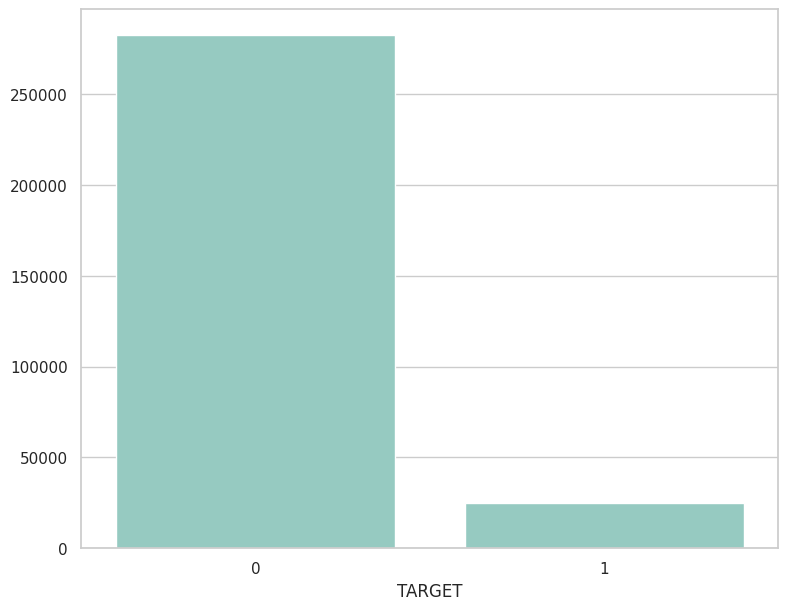

In [75]:
sns.barplot(x=df['TARGET'].value_counts().index, y=df['TARGET'].value_counts().values)

In [76]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['TARGET'] = y_resampled

df_resampled.head()

<ipython-input-76-6e78366990a9>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['TARGET'] = y_resampled


SK_ID_CURR  NAME_CONTRACT_TYPE_x  CODE_GENDER  FLAG_OWN_CAR  \
0      100002                     0            1             0   
1      100003                     0            0             0   
2      100004                     1            1             1   
3      100006                     0            0             0   
4      100007                     0            1             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
0                1             0          202500.0      406597.5   
1                0             0          270000.0     1293502.5   
2                1             0           67500.0      135000.0   
3                1             0          135000.0      312682.5   
4                1             0          121500.0      513000.0   

   AMT_ANNUITY_x  AMT_GOODS_PRICE_x  ...  CNT_PAYMENT  NAME_YIELD_GROUP  \
0        24700.5           351000.0  ...    24.000000          3.000000   
1        35698.5          1129500.0  ...    10.000000          3.666667   
2         6750.0           135000.0  ...     4.000000          4.000000   
3        29686.5           297000.0  ...    19.333333          1.333333   
4        21865.5           513000.0  ...    20.666667          2.500000   

   PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  \
0            15.000000            365243.0     -565.000000   
1             9.000000            365243.0    -1274.333333   
2            14.000000            365243.0     -784.000000   
3             5.000000            365243.0     -662.555556   
4             8.166667            365243.0    -1191.166667   

   DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
0                 125.000000     -25.000000        -17.000000   
1               -1004.333333   -1054.333333      -1047.333333   
2                -694.000000    -724.000000       -714.000000   
3                -119.222222    -481.666667       -450.222222   
4                -757.833333    -939.333333       -920.333333   

   NFLAG_INSURED_ON_APPROVAL  TARGET  
0                   0.000000       1  
1                   0.666667       0  
2                   0.000000       0  
3                   0.000000       0  
4                   0.500000       0  

[5 rows x 142 columns]

<Figure size 300x100 with 0 Axes>

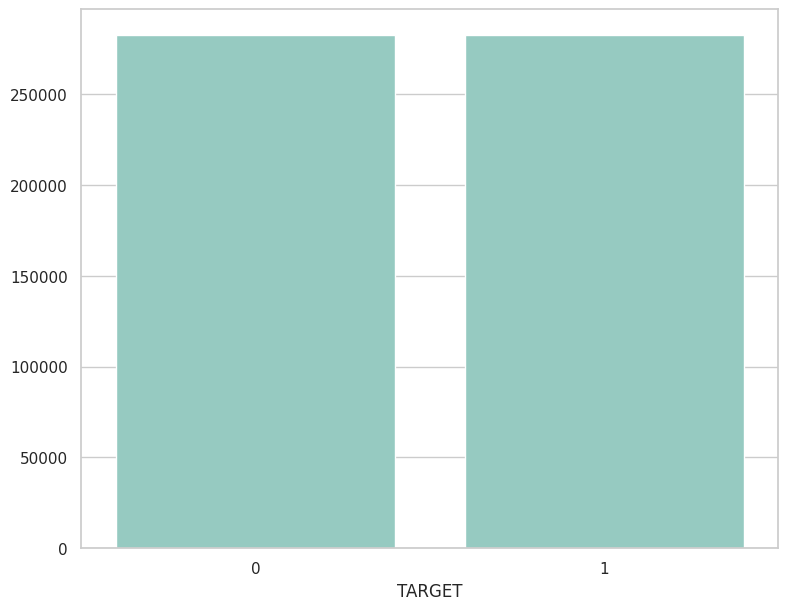

<Figure size 300x100 with 0 Axes>

In [77]:
sns.barplot(x=df_resampled['TARGET'].value_counts().index, y=df_resampled['TARGET'].value_counts().values)
plt.figure(figsize=(3, 1))

In [78]:
df_resampled.shape

(565372, 142)

## **a. Data Splitting** 

In [79]:
X = df_resampled.drop('TARGET', axis=1)
y = df_resampled['TARGET']

In [80]:
# splitting X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(339223, 141) (226149, 141) (339223,) (226149,)


## **b. Build Model** 

In [81]:
# random forest
rf = RandomForestClassifier(random_state= 11,
                            n_jobs = -1,
                            max_depth = 20,
                            n_estimators = 38,
                            oob_score = True)
rf = rf.fit(X_train, y_train)
print(rf)

RandomForestClassifier(max_depth=20, n_estimators=38, n_jobs=-1, oob_score=True,
                       random_state=11)


In [82]:
y_rf = rf.predict(X_train)
y_rf_test = rf.predict(X_test)

In [83]:
# evaluasi random forest
print(classification_report(y_train, y_rf))
print(confusion_matrix(y_train, y_rf))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    169658
           1       0.99      0.97      0.98    169565

    accuracy                           0.98    339223
   macro avg       0.98      0.98      0.98    339223
weighted avg       0.98      0.98      0.98    339223

[[168253   1405]
 [  5404 164161]]


In [84]:
# evaluasi random forest
print(classification_report(y_test, y_rf_test))
print(confusion_matrix(y_test, y_rf_test))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95    113028
           1       0.98      0.91      0.94    113121

    accuracy                           0.94    226149
   macro avg       0.95      0.94      0.94    226149
weighted avg       0.95      0.94      0.94    226149

[[110696   2332]
 [ 10506 102615]]


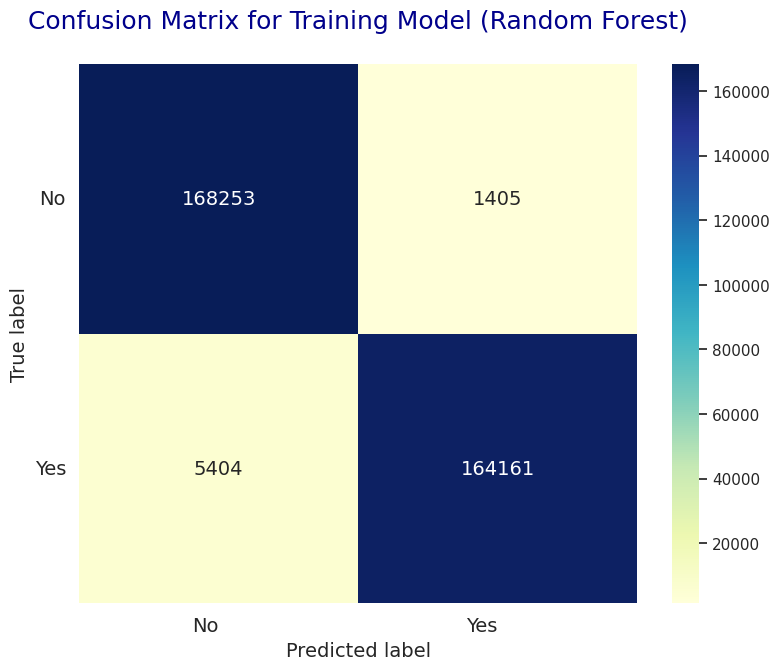

In [85]:
confusion_matrix_app = pd.DataFrame((confusion_matrix(y_train, y_rf)), ('No', 'Yes'), ('No', 'Yes'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_app, annot=True, annot_kws={'size':14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model (Random Forest)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

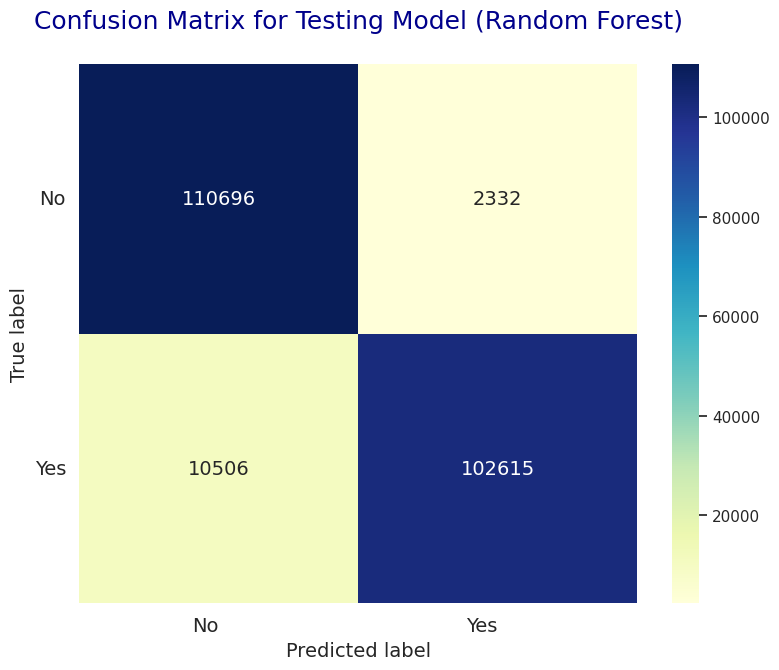

In [86]:
confusion_matrix_app = pd.DataFrame((confusion_matrix(y_test, y_rf_test)), ('No', 'Yes'), ('No', 'Yes'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_app, annot=True, annot_kws={'size':14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model (Random Forest)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

In [87]:
# hyperparameter tuning
rf_a = RandomForestClassifier(random_state= 42,
                              n_jobs = -1,
                              oob_score = True)

In [88]:
param_dist = {
    'n_estimators': [25, 38, 50],  # Jumlah estimators (pohon)
    'max_depth': [None, 10, 20, 30, 40],     # Kedalaman maksimal pohon
    'min_samples_split': [2, 5, 10],         # Jumlah minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4],           # Jumlah minimum sampel di daun
    'max_features': ['auto', 'sqrt'], # Jumlah fitur yang dipertimbangkan              # Penggunaan bootstrap
}

In [89]:
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=10, cv=5, n_jobs=-1, verbose=2, 
                                   scoring='accuracy', random_state=11)
# Melakukan pencarian
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=20,
                                                    n_estimators=38, n_jobs=-1,
                                                    oob_score=True,
                                                    random_state=11),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [25, 38, 50]},
                   random_state=11, scoring='accuracy', verbose=2)

In [90]:
# from sklearn.model_selection import GridSearchCV

# grid_search = GridSearchCV(estimator = rf_a,
#                            param_grid = params,
#                            cv = 4, n_jobs = -1, 
#                            verbose = 1, scoring = 'accuracy')
# grid_search.fit(X_train, y_train)

In [91]:
random_search.best_score_

0.9466781459674198

In [92]:
rf_best = random_search.best_estimator_
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, n_estimators=50,
                       n_jobs=-1, oob_score=True, random_state=11)

In [93]:
# RandomForestClassifier(max_depth=20, max_features='auto', min_samples_leaf=5,
#                        n_jobs=-1, oob_score=True, random_state=42)

In [94]:
y_rfa = rf_best.predict(X_train)
y_rf_best = rf_best.predict(X_test)

In [95]:
print(classification_report(y_train, y_rfa))
print(confusion_matrix(y_train, y_rfa))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    169658
           1       1.00      0.99      0.99    169565

    accuracy                           0.99    339223
   macro avg       0.99      0.99      0.99    339223
weighted avg       0.99      0.99      0.99    339223

[[169548    110]
 [  1802 167763]]


In [96]:
print(classification_report(y_test, y_rf_best))
print(confusion_matrix(y_test, y_rf_best))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95    113028
           1       0.99      0.91      0.95    113121

    accuracy                           0.95    226149
   macro avg       0.95      0.95      0.95    226149
weighted avg       0.95      0.95      0.95    226149

[[111867   1161]
 [ 10408 102713]]


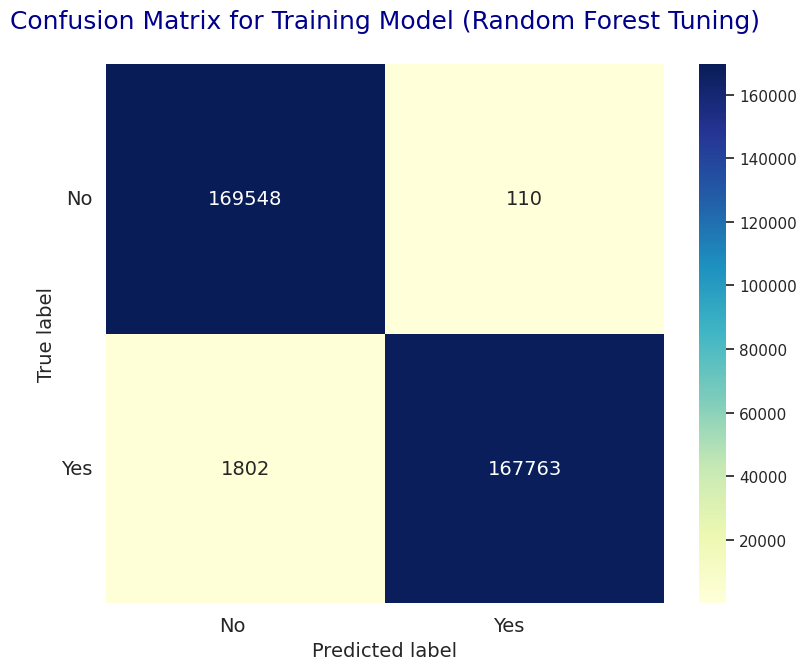

In [97]:
confusion_matrix_app = pd.DataFrame((confusion_matrix(y_train, y_rfa)), ('No', 'Yes'), ('No', 'Yes'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_app, annot=True, annot_kws={'size':14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model (Random Forest Tuning)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

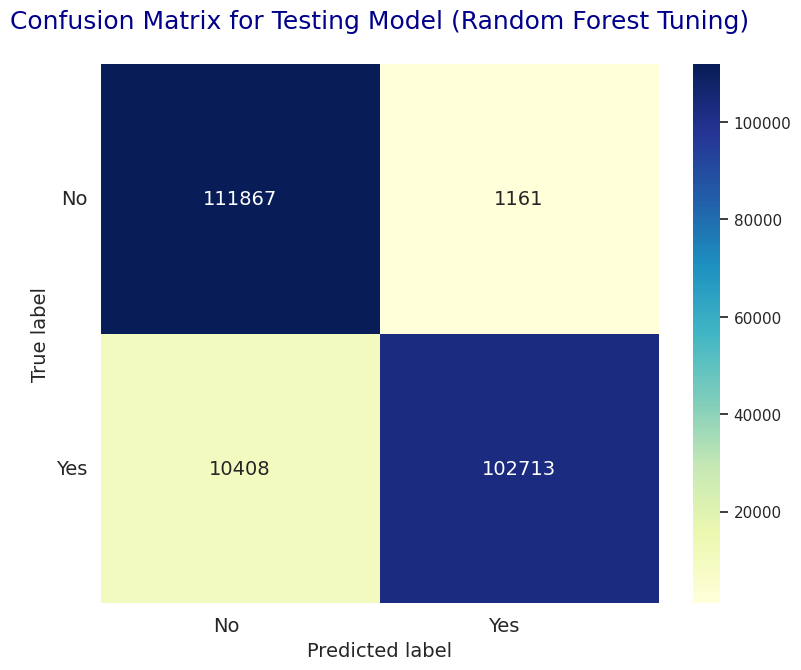

In [98]:
confusion_matrix_app = pd.DataFrame((confusion_matrix(y_test, y_rf_best)), ('No', 'Yes'), ('No', 'Yes'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_app, annot=True, annot_kws={'size':14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model (Random Forest Tuning)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

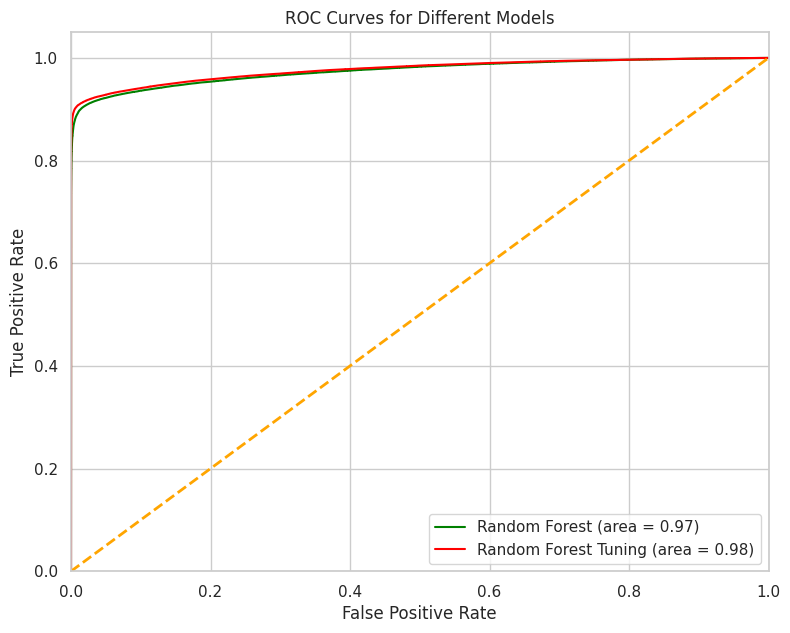

In [99]:
# Get predicted probabilities for each model
y_rf_proba = rf.predict_proba(X_test)[:, 1]
y_rfa_proba = rf_best.predict_proba(X_test)[:, 1]

# Compute the ROC curve and AUC score for each model
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_rf_proba)
roc_auc_rf = roc_auc_score(y_test, y_rf_proba)

fpr_rfa, tpr_rfa, thresholds_rfa = roc_curve(y_test, y_rfa_proba)
roc_auc_rfa = roc_auc_score(y_test, y_rfa_proba)


# Plot the ROC curves
plt.plot(fpr_rf, tpr_rf, color='green', label='Random Forest (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_rfa, tpr_rfa, color='red', label='Random Forest Tuning (area = %0.2f)' % roc_auc_rfa)


plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc="lower right")
plt.show()


Peningkatan Kinerja: Hyperparameter tuning berhasil meningkatkan kinerja model. Meskipun model sudah memiliki kinerja yang sangat baik sebelum tuning, tuning parameter memberikan sedikit peningkatan, yang membuat model lebih akurat dalam memprediksi kemampuan pemohon pinjaman untuk membayar kembali.